# Data Exploration

Joeri R. Hermans                    
*Departement of Data Science & Knowledge Engineering*          
*Maastricht University, The Netherlands*        

In [ ]:
!(date +%d\ %B\ %G)

In this notebook we will explore the physics data that has been granted to us. This data is intended for two purposes. The first is event classification, and the second is track reconstruction. Since event classification is a "defacto" task for machine learning, we will start by building a data structure for this, since at the same time it will give some insight in the data. Which we surely will need for track reconstruction.

In [ ]:
import numpy as np
import pandas as pd
import os

## Preprocessing

List the CMS event files in the data directory.

In [ ]:
data_directory = "../data/"
event_types = os.listdir(data_directory)

# List the event types.
for e in event_types:
    print(e)

In order to check the compatibility of the event files, we first have to check if they all share the same event attributes. We do this by reading every event type, and collect its attributes.

In [ ]:
columns = []

# Fetch the columns names from the events.
for e in event_types:
    tracker_files = os.listdir(data_directory + e)
    tracker_file = tracker_files[0]
    data = np.load(data_directory + e + "/" + tracker_file)
    columns.append(data.dtype.names)

# Check if the columns have the same attributes.
num_columns = len(columns)
c = columns[0]
equal = True
for i in range(1, num_columns):
    equal &= (c == columns[i])
    if not equal:
        break

print("Equal attributes among all events: " + str(equal))

For classification purposes, we need to assign a label to the events. This can be done by simply appending a label attribute to the events. We will assign a string as a label which we define in the following dictionary.

In [ ]:
labels = {}
labels['RelValWjet_Pt_3000_3500_13_GEN-SIM-RECO_evt3150'] = 'Wjet'
labels['RelValSMS-T1tttt_mGl-1500_mLSP-100_13_GEN-SIM-RECO_evt1750'] = 'SMS-T1tttt_mGl'
labels['RelValRSGravitonToGaGa_13_GEN-SIM-RECO_evt2000'] = 'RSGravitonToGaGa'
labels['RelValPhiToMuMu_13_GEN-SIM-RECO_evt4358'] = 'PhiToMuMu'
labels['RelValH125GGgluonfusion_13_GEN-SIM-RECO_evt4500'] = 'H125GGgluonfusion'
labels['RelValDisplacedSUSY_stopToBottom_M_300_1000mm_13_GEN-SIM-RECO_evt3500'] = 'DisplacedSUSY_stopToBottom'

In [ ]:
dataframes = []

# Now we read all the track parameters in a Pandas dataframe.
for e in event_types:
    label = labels[e]
    path = data_directory + e + "/"
    files = os.listdir(path)
    num_files = len(files)
    file_path = path + "trackparams0.npy"
    data = np.load(file_path)
    for i in range(1, num_files):
        file_path = path + "trackparams" + str(i) + ".npy"
        data = np.append(data,np.load(file_path))
    df = pd.DataFrame(data)
    num_elements = df.shape[0]
    df['label'] = pd.Series(np.array([label for _ in range(num_elements)]), index=df.index)
    dataframes.append(df)

In [ ]:
# Concatinate all the event files into a single dataframe.
df = pd.concat(dataframes)

In [ ]:
# Shuffle the dataframe a few times.
for i in range(0, 10):
    df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Write the Pandas dataframe to a file for later processing.
df.to_csv("../events.csv")

In [ ]:
# Put the events file on HDFS.
!hdfs dfs -rm data/events.csv
!hdfs dfs -copyFromLocal ../events.csv data/

## Analysis

### Spark setup

Due to the size of the dataset, we parallelize the operations of our analysis using Apache Spark. For this, we first need to setup our Spark context, and specify other variables which allow use to tune the resources.

In [1]:
%matplotlib inline

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os

from pyspark import SparkContext
from pyspark import SparkConf

from distkeras.transformers import *
from pyspark.sql.functions import mean
from pyspark.sql.functions import stddev_pop

from distkeras.utils import *

import os

# Use the DataBricks CSV reader, this has some nice functionality regarding invalid values.
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.10:1.4.0 pyspark-shell'

Using TensorFlow backend.


In [2]:
# Modify these variables according to your needs.
application_name = "CMS Event Analysis"
using_spark_2 = False
local = False
path_data = "data/events.csv"
if local:
    # Tell master to use local resources.
    master = "local[*]"
    num_processes = 3
    num_executors = 1
else:
    # Tell master to use YARN.
    master = "yarn-client"
    num_executors = 20
    num_processes = 1

# This variable is derived from the number of cores and executors,
# and will be used to assign the number of model trainers.
num_workers = num_executors * num_processes

print("Number of desired executors: " + `num_executors`)
print("Number of desired processes / executor: " + `num_processes`)
print("Total number of workers: " + `num_workers`)

Number of desired executors: 20
Number of desired processes / executor: 1
Total number of workers: 20


In [3]:
# Do not change anything here.
conf = SparkConf()
conf.set("spark.app.name", application_name)
conf.set("spark.master", master)
conf.set("spark.executor.cores", `num_processes`)
conf.set("spark.executor.instances", `num_executors`)
conf.set("spark.executor.memory", "4g")
conf.set("spark.locality.wait", "0")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer");

# Check if the user is running Spark 2.0 +
if using_spark_2:
    sc = SparkSession.builder.config(conf=conf) \
            .appName(application_name) \
            .getOrCreate()
else:
    # Create the Spark context.
    sc = SparkContext(conf=conf)
    # Add the missing imports
    from pyspark import SQLContext
    sqlContext = SQLContext(sc)

In [4]:
# Check if we are using Spark 2.0
if using_spark_2:
    reader = sc
else:
    reader = sqlContext
# Read the dataset.
dataset = reader.read.format('com.databricks.spark.csv') \
                .options(header='true', inferSchema='true') \
                .load(path_data)
# Repartition the dataset.
dataset = dataset.repartition(num_workers)
dataset.cache()

# Count the total number of events.
print("Total number of events: " + str(dataset.count()))

Total number of events: 1747413


In [5]:
# Register the dataframe as a temporary table so we can use regular SQL.
dataset.registerTempTable("dataset")

In [6]:
# Extract columns which are interesting to us.
features = dataset.columns
del features[0]
features.remove('run')
features.remove('TrackId')
features.remove('evt')
features.remove('label')
# Remove the pixel detector hits.
for i in range(0, 5):
    features.remove("pix_" + str(i) + "_x")
    features.remove("pix_" + str(i) + "_y")
    features.remove("pix_" + str(i) + "_z")
# Remove the silicon detector hits.
for i in range(0, 50):
    features.remove("sis_" + str(i) + "_x")
    features.remove("sis_" + str(i) + "_y")
    features.remove("sis_" + str(i) + "_z")

In [7]:
label_counts = dataset.groupBy(dataset.label).count().collect()

num_labels = len(label_counts)
x = []
y = []
for i in range(0, num_labels):
    label_counts[i] = label_counts[i].asDict()
    x.append(i)
    y.append(label_counts[i]['count'])

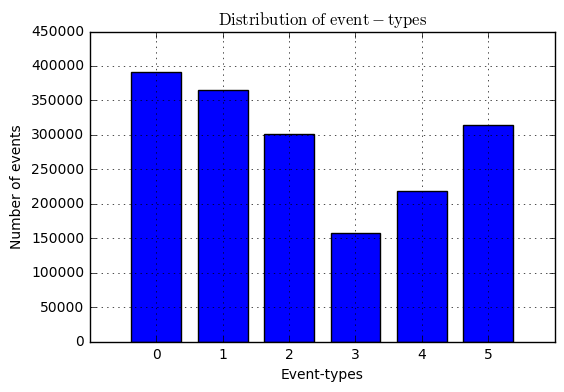

0	Wjet
1	SMS-T1tttt_mGl
2	DisplacedSUSY_stopToBottom
3	RSGravitonToGaGa
4	PhiToMuMu
5	H125GGgluonfusion


In [8]:
plt.bar(np.arange(num_labels), y, 0.75, align='center',color="blue")
plt.xlabel('Event-types')
plt.ylabel('Number of events')
plt.title(r'$\mathrm{Distribution\ of\ event-types}$')
plt.xticks(x)
plt.ylim([0,450000])
plt.grid(True)

plt.show()

# Also make an array of labels for later use.
labels = []

# Print the legend:
for i in range(0, num_labels):
    labels.append(label_counts[i]['label'])
    print(str(i) + "\t" + str(label_counts[i]['label']))

In [9]:
# For every feature, collect the mean, std, min, max.
for f in features:
    dataset.select(f).describe().show()

+-------+-----------------+
|summary|             lumi|
+-------+-----------------+
|  count|          1747413|
|   mean| 69.1543212737916|
| stddev|45.67539657925926|
|    min|                1|
|    max|              180|
+-------+-----------------+

+-------+--------------------+
|summary|              charge|
+-------+--------------------+
|  count|             1747413|
|   mean|0.017842948404298238|
| stddev|  0.9998410880159566|
|    min|                  -1|
|    max|                   1|
+-------+--------------------+

+-------+------------------+
|summary|              chi2|
+-------+------------------+
|  count|           1747413|
|   mean|20.794972908466512|
| stddev|  75.2278000461964|
|    min| 6.70480598125E-12|
|    max|     28457.0039062|
+-------+------------------+

+-------+------------------+
|summary|              ndof|
+-------+------------------+
|  count|           1747413|
|   mean| 15.14307378965362|
| stddev|11.598534403812556|
|    min|              -2.0|
| 

In [10]:
# Collect some statistics per event.
df = sqlContext.sql("SELECT \
                     evt, \
                     label, \
                     AVG(charge) AS avg_charge, \
                     AVG(qoverp) AS avg_qoverp, \
                     AVG(theta) AS avg_theta, \
                     AVG(lambda) AS avg_lambda, \
                     AVG(dxy) AS avg_dxy, \
                     AVG(d0) AS avg_d0, \
                     AVG(dsz) AS avg_dsz, \
                     AVG(dz) AS avg_dz, \
                     AVG(p) AS avg_p, \
                     AVG(pt) AS avg_pt, \
                     AVG(px) AS avg_px, \
                     AVG(py) AS avg_py, \
                     AVG(pz) AS avg_pz, \
                     AVG(eta) AS avg_eta, \
                     AVG(phi) AS avg_phi, \
                     AVG(vx) AS avg_vx, \
                     AVG(vy) AS avg_vy, \
                     AVG(vz) AS avg_vz, \
                     COUNT(*) AS num_events \
                     FROM dataset GROUP BY evt, label \
                     ORDER BY evt")

# Select the required columns for plotting.
df.cache()

DataFrame[evt: int, label: string, avg_charge: double, avg_qoverp: double, avg_theta: double, avg_lambda: double, avg_dxy: double, avg_d0: double, avg_dsz: double, avg_dz: double, avg_p: double, avg_pt: double, avg_px: double, avg_py: double, avg_pz: double, avg_eta: double, avg_phi: double, avg_vx: double, avg_vy: double, avg_vz: double, num_events: bigint]

In [11]:
def plot_distribution(column, xlabel=None, ylabel=None, xlim=None, ylim=None):
    data = {}
    # Round the specified column.
    d = df.map(lambda x: new_dataframe_row(x, column + '_rounded', int(round(x[column])))).toDF()
    try:
        sqlContext.dropTempTable("averaged_data")
    except:
        print("Table does not exists in the SQL Context.")
    # Register the table, so we can use regular SQL.
    d.registerTempTable("averaged_data")
    # Fetcht the desired data.
    d = sqlContext.sql("SELECT " + column + "_rounded, label, COUNT(*) AS num_events \
                        FROM averaged_data \
                        GROUP BY " + column + "_rounded, label \
                        ORDER BY " + column + "_rounded, label")
    # Estimate the minimum bin, and the maximum bin.
    min = d.select(column + "_rounded").rdd.min()[column + '_rounded']
    max = d.select(column + "_rounded").rdd.max()[column + '_rounded']
    num_elements = max - min + 2
    # Collect all the data for plotting.
    d = d.collect()
    # For every array, allocate a data array.
    for label in labels:
        data[label] = np.zeros(num_elements)
    # Prepare the x-axis.
    x = np.arange(0, num_elements)
    # Structure all the data for plotting.
    for r in d:
        # Fetch the information from the current row.
        r = r.asDict()
        index = r[column + '_rounded']
        label = r['label']
        n = r['num_events']
        # Store the information in our datastructure.
        data[label][index] = n
    # Plot the distributions of the selected features.
    num_labels = len(labels)
    for label in labels:
        print("Class: " + label)
        plt.plot(x, data[label])
        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)
        plt.grid(True)
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        plt.show()

Table does not exists in the SQL Context.
Class: Wjet


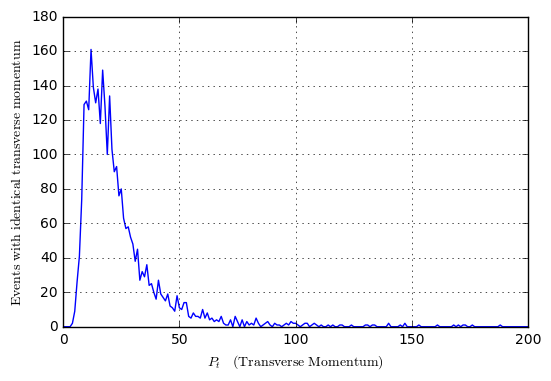

Class: SMS-T1tttt_mGl


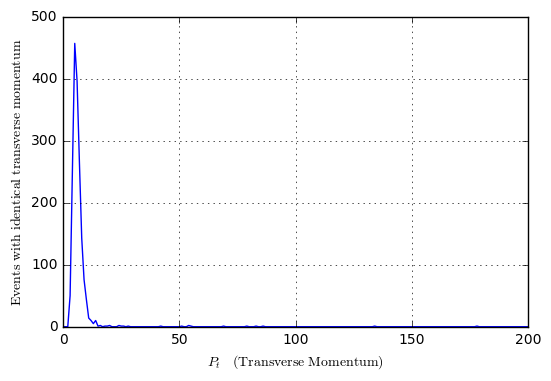

Class: DisplacedSUSY_stopToBottom


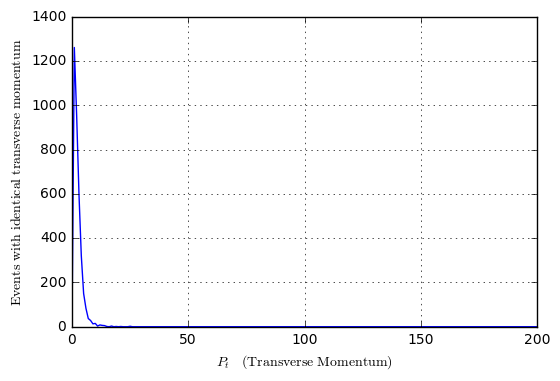

Class: RSGravitonToGaGa


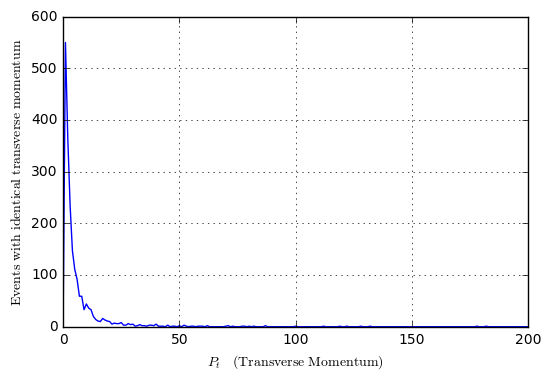

Class: PhiToMuMu


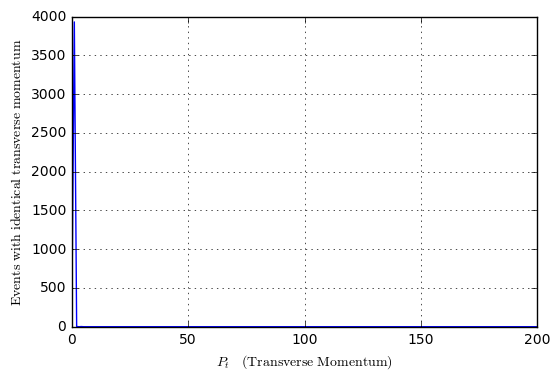

Class: H125GGgluonfusion


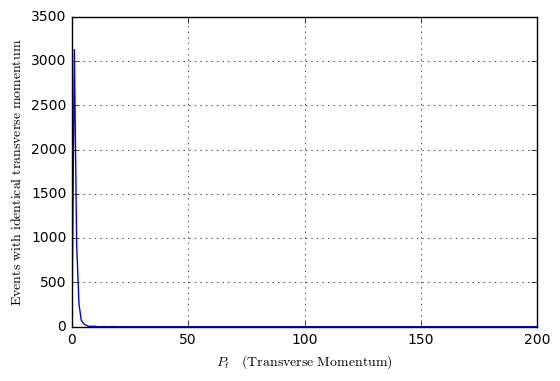

In [12]:
plot_distribution('avg_pt', xlim=[0, 200], \
                  xlabel=r"$P_t\quad\mathrm{(Transverse\ Momentum)}$", \
                  ylabel=r"$\mathrm{Events\ with\ identical\ transverse\ momentum}$")

Class: Wjet


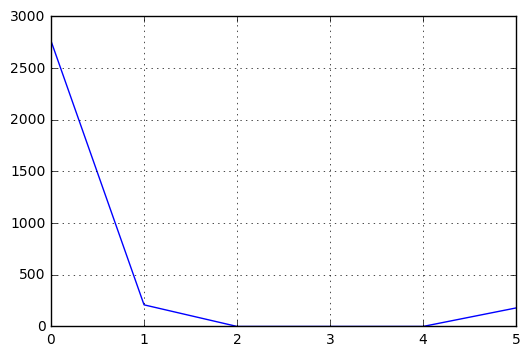

Class: SMS-T1tttt_mGl


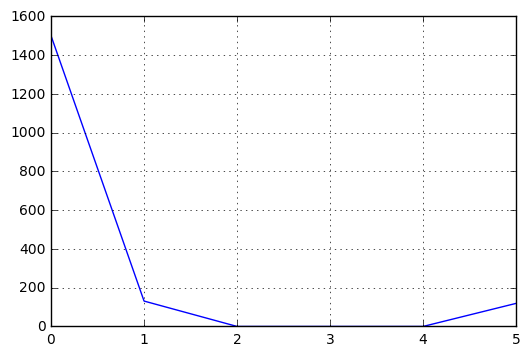

Class: DisplacedSUSY_stopToBottom


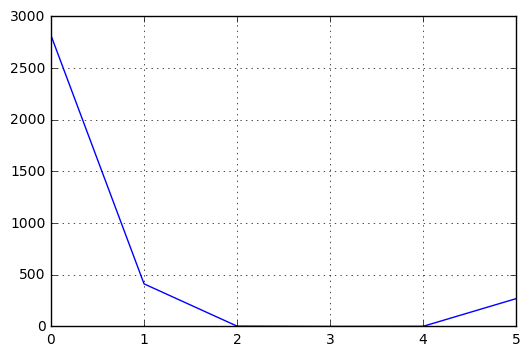

Class: RSGravitonToGaGa


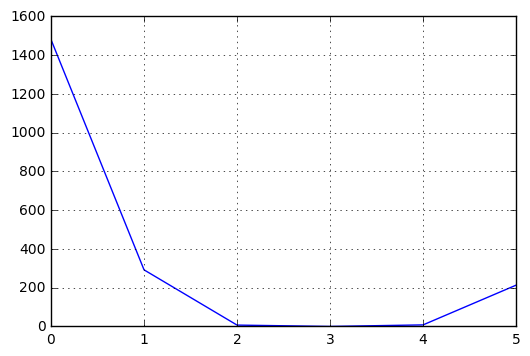

Class: PhiToMuMu


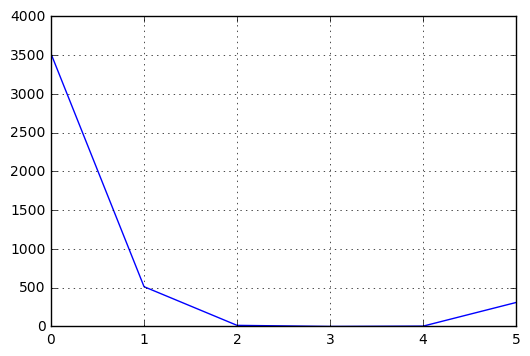

Class: H125GGgluonfusion


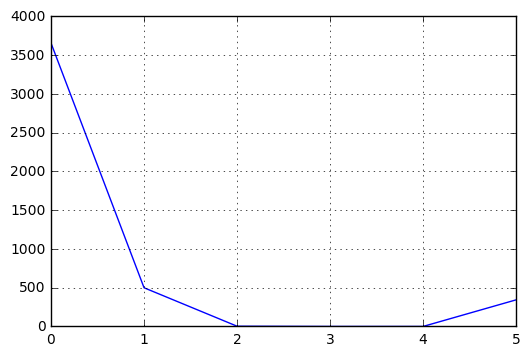

In [13]:
plot_distribution('avg_eta')

Class: Wjet


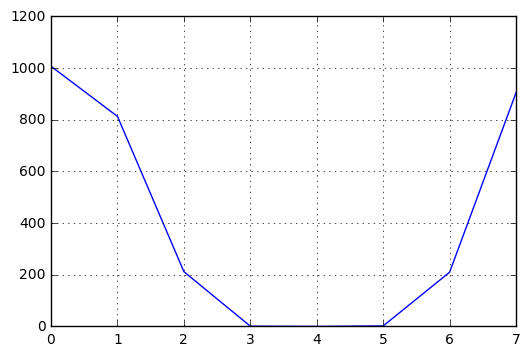

Class: SMS-T1tttt_mGl


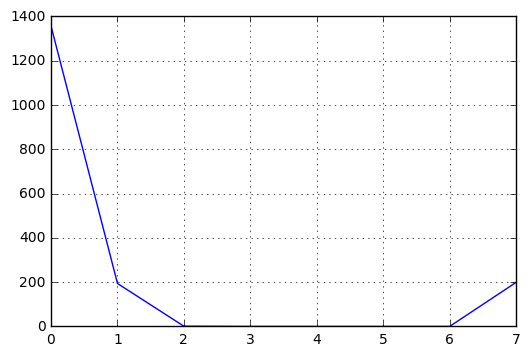

Class: DisplacedSUSY_stopToBottom


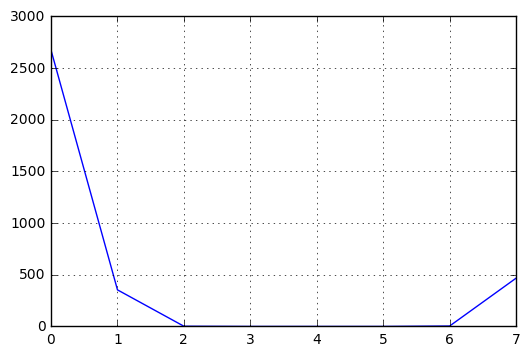

Class: RSGravitonToGaGa


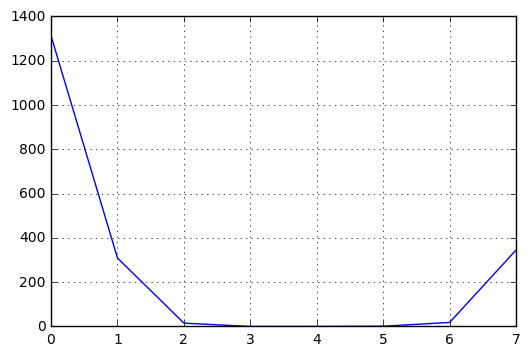

Class: PhiToMuMu


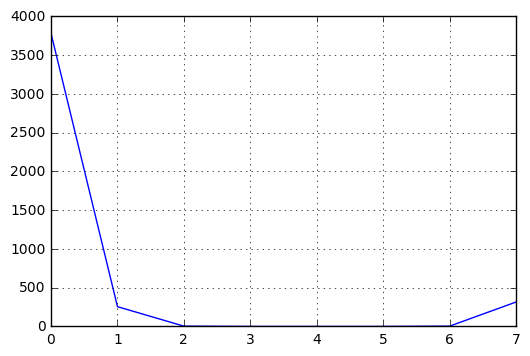

Class: H125GGgluonfusion


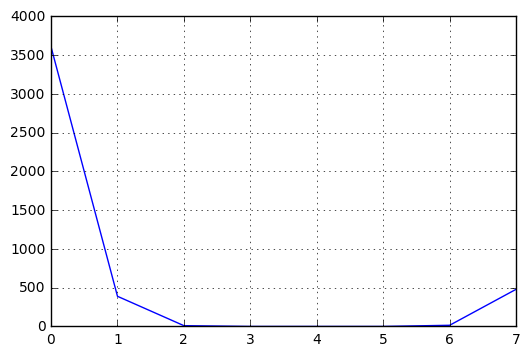

In [14]:
plot_distribution('avg_phi')

Class: Wjet


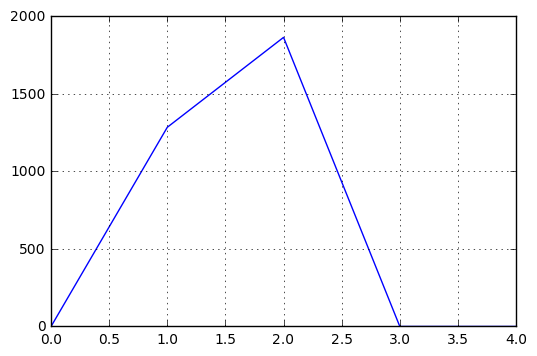

Class: SMS-T1tttt_mGl


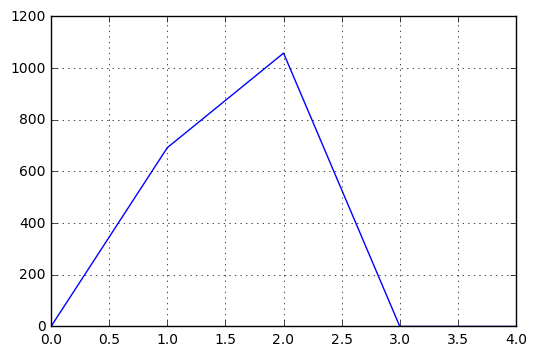

Class: DisplacedSUSY_stopToBottom


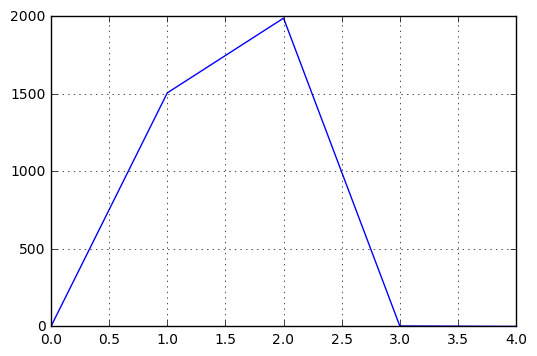

Class: RSGravitonToGaGa


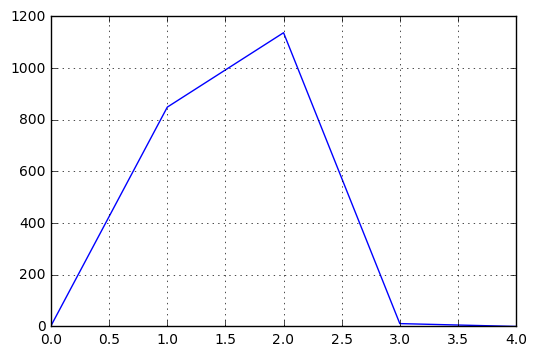

Class: PhiToMuMu


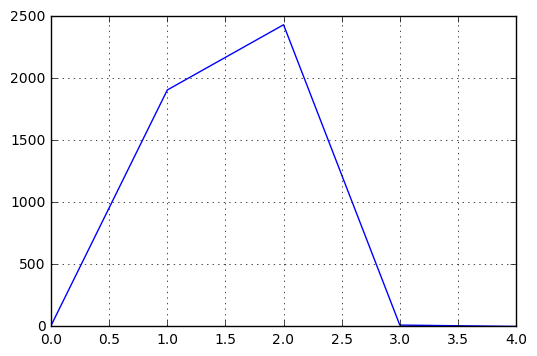

Class: H125GGgluonfusion


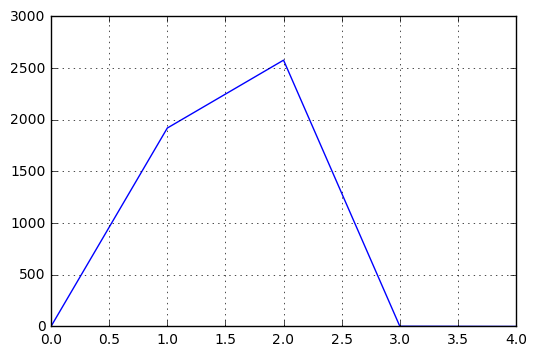

In [15]:
plot_distribution('avg_theta')

Class: Wjet


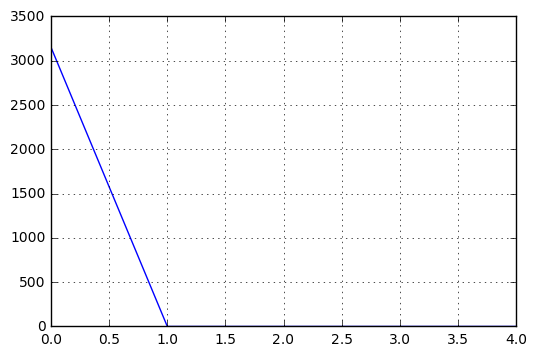

Class: SMS-T1tttt_mGl


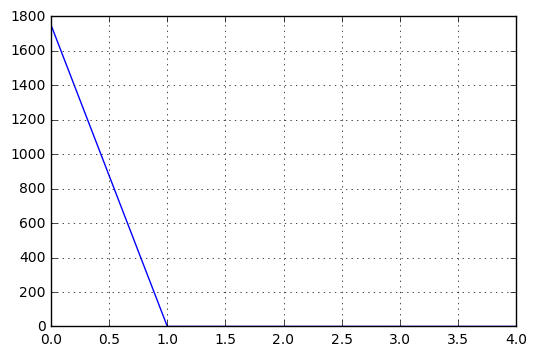

Class: DisplacedSUSY_stopToBottom


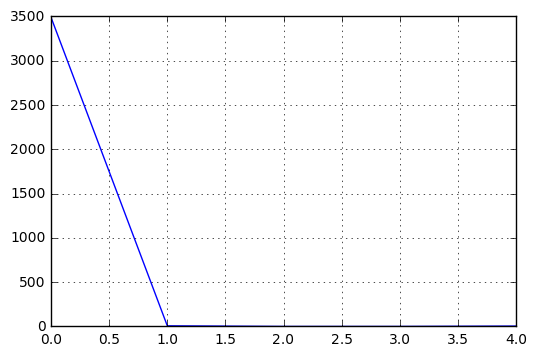

Class: RSGravitonToGaGa


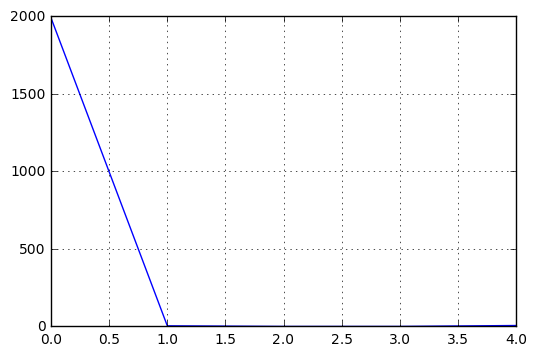

Class: PhiToMuMu


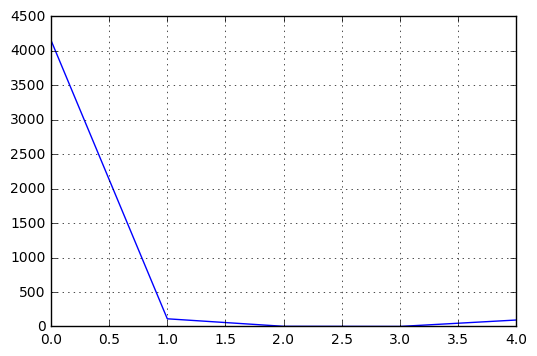

Class: H125GGgluonfusion


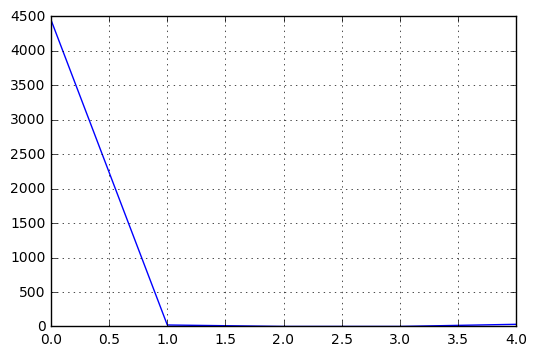

In [16]:
plot_distribution('avg_qoverp')

Class: Wjet


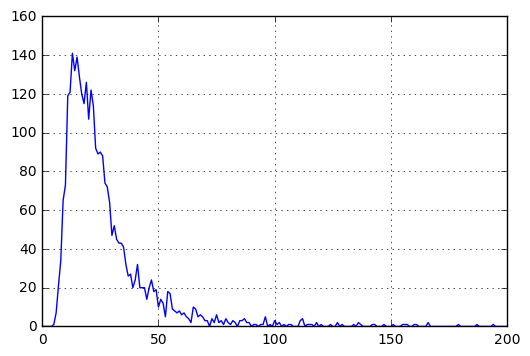

Class: SMS-T1tttt_mGl


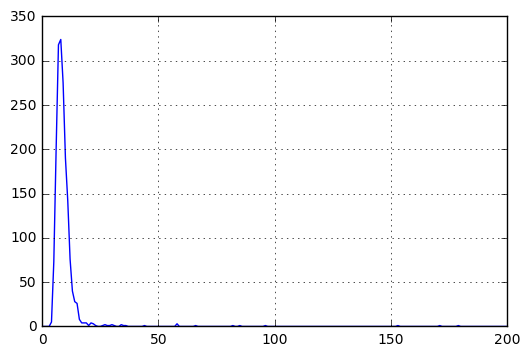

Class: DisplacedSUSY_stopToBottom


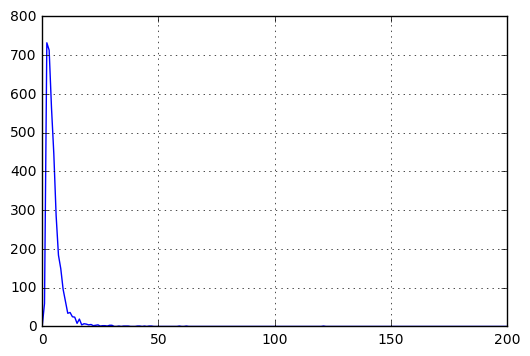

Class: RSGravitonToGaGa


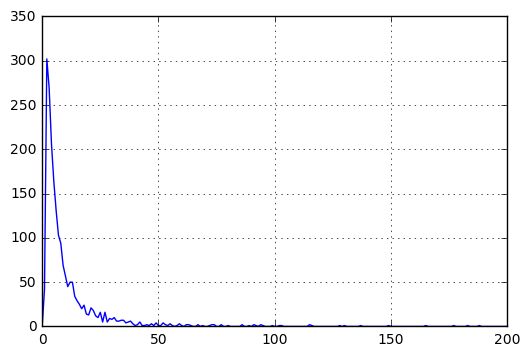

Class: PhiToMuMu


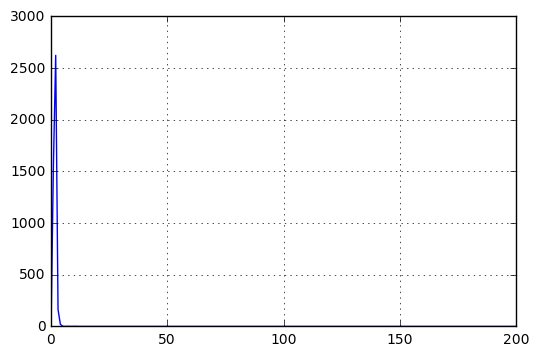

Class: H125GGgluonfusion


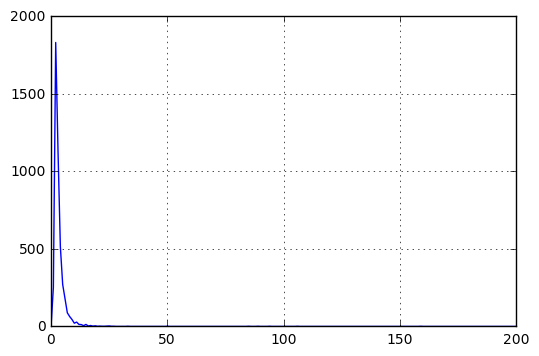

In [17]:
plot_distribution('avg_p', xlim=[0, 200])

Class: Wjet


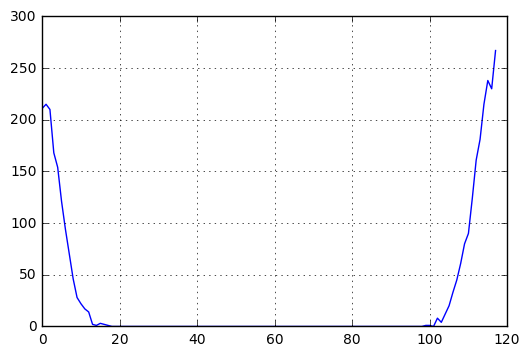

Class: SMS-T1tttt_mGl


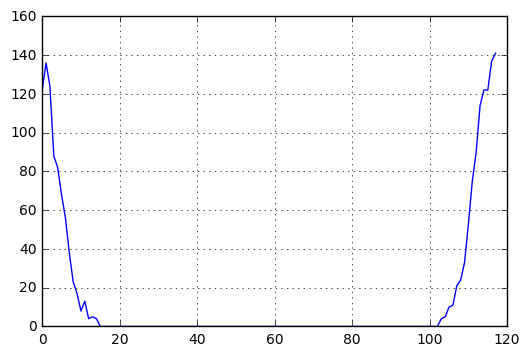

Class: DisplacedSUSY_stopToBottom


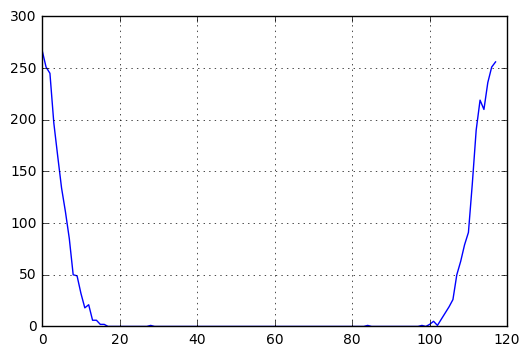

Class: RSGravitonToGaGa


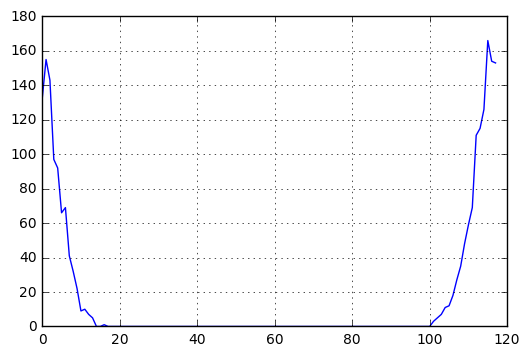

Class: PhiToMuMu


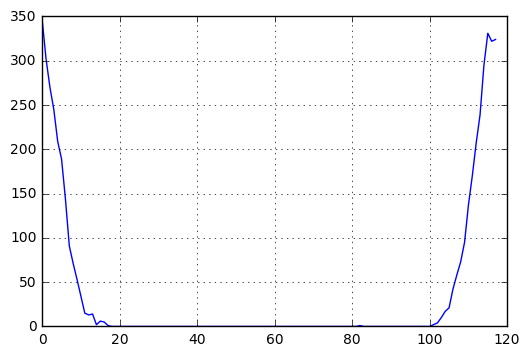

Class: H125GGgluonfusion


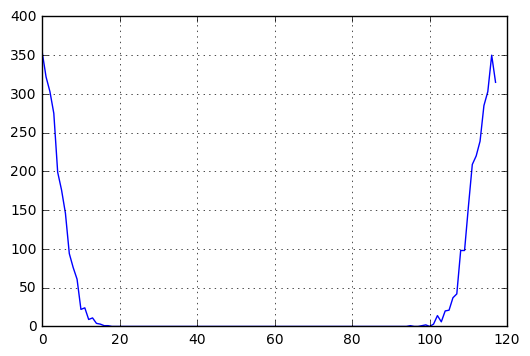

In [18]:
plot_distribution('avg_dz')

Class: Wjet


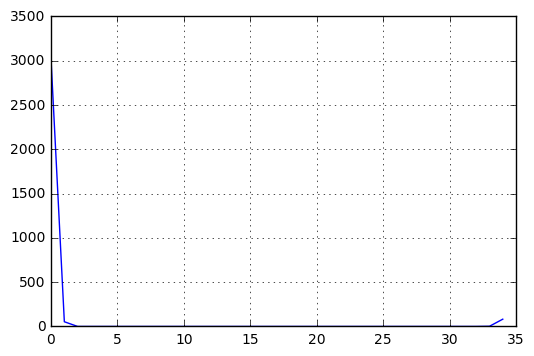

Class: SMS-T1tttt_mGl


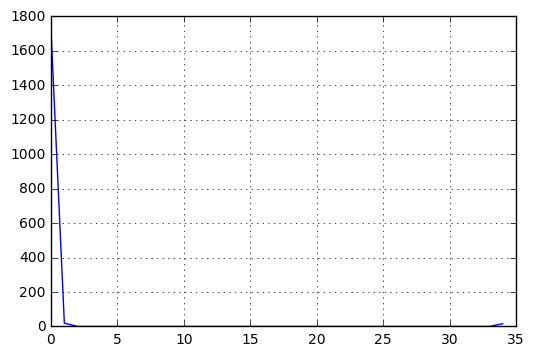

Class: DisplacedSUSY_stopToBottom


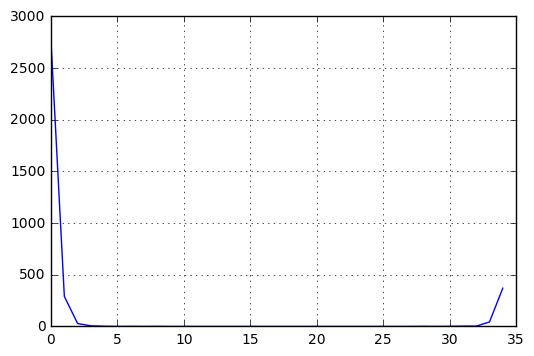

Class: RSGravitonToGaGa


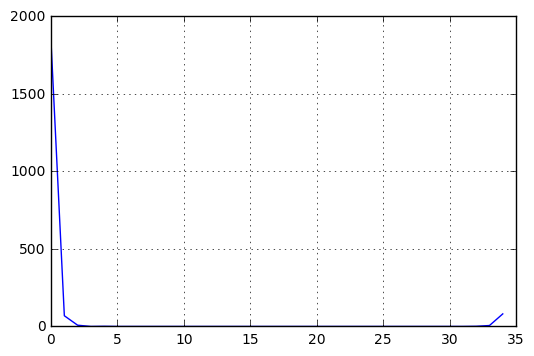

Class: PhiToMuMu


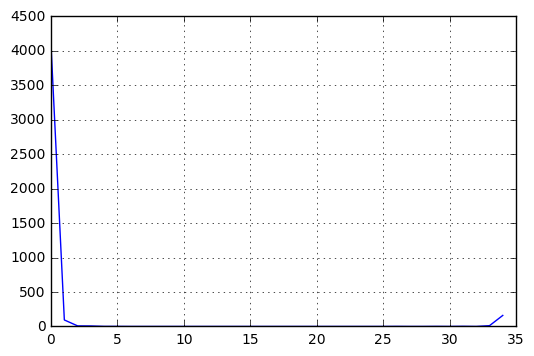

Class: H125GGgluonfusion


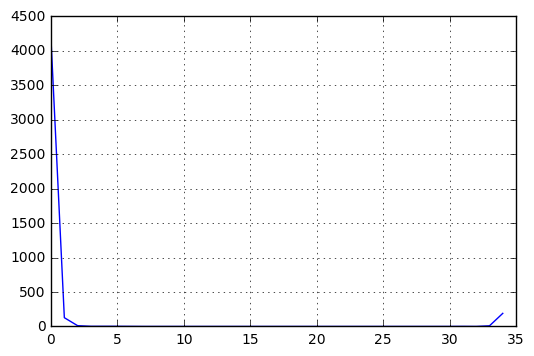

In [19]:
plot_distribution('avg_dxy')

Class: Wjet


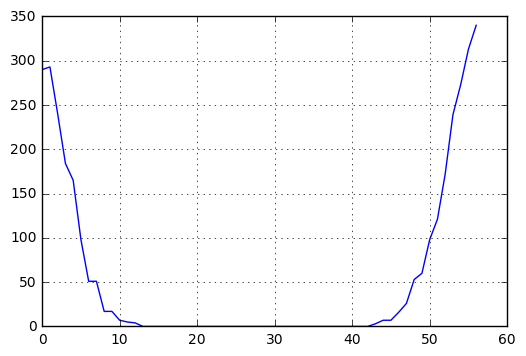

Class: SMS-T1tttt_mGl


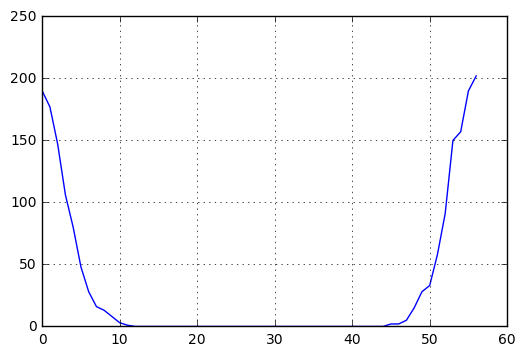

Class: DisplacedSUSY_stopToBottom


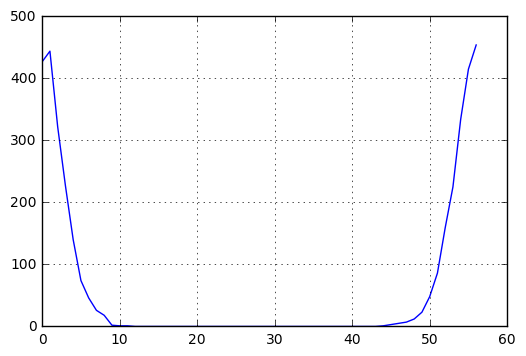

Class: RSGravitonToGaGa


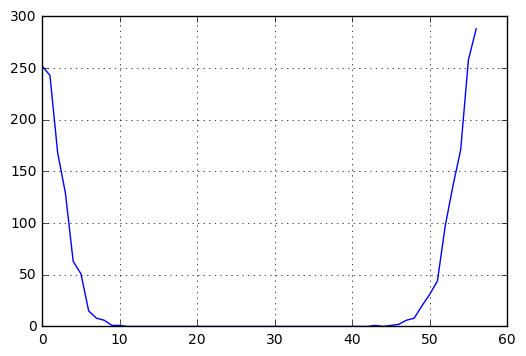

Class: PhiToMuMu


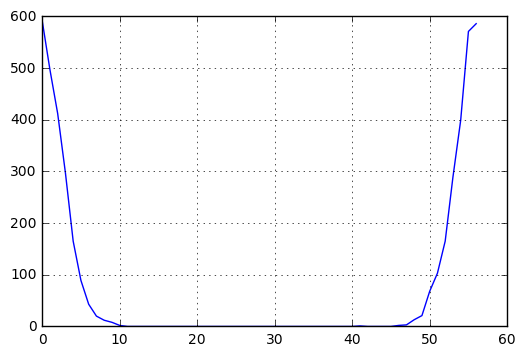

Class: H125GGgluonfusion


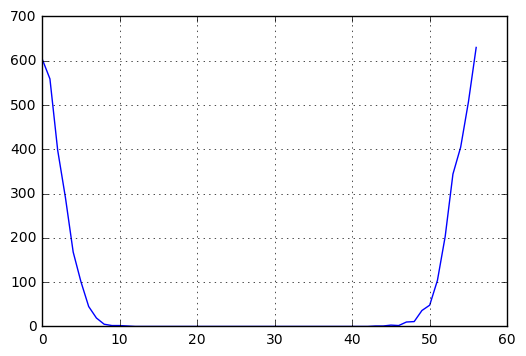

In [20]:
plot_distribution('avg_dsz')

Class: Wjet


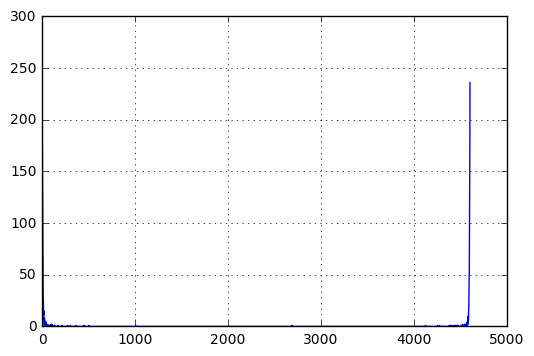

Class: SMS-T1tttt_mGl


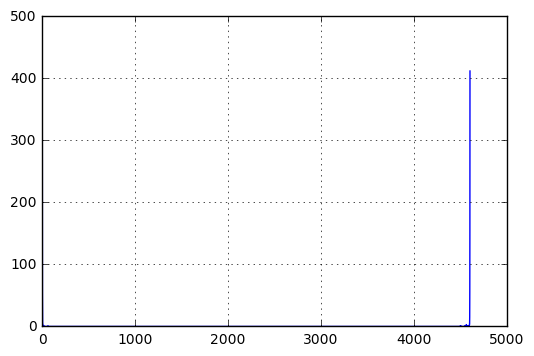

Class: DisplacedSUSY_stopToBottom


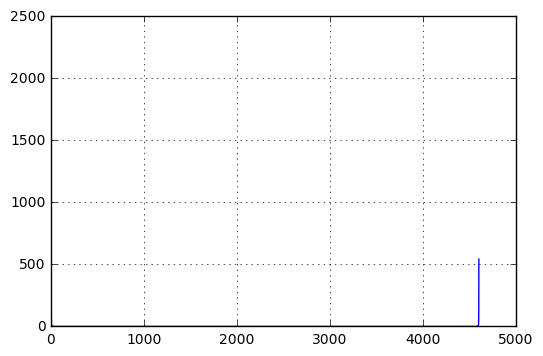

Class: RSGravitonToGaGa


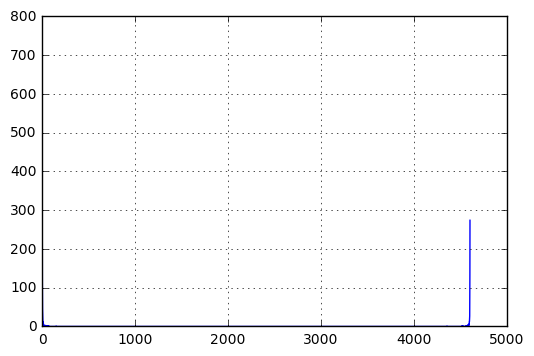

Class: PhiToMuMu


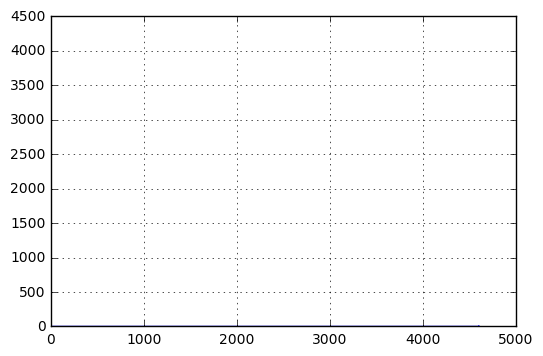

Class: H125GGgluonfusion


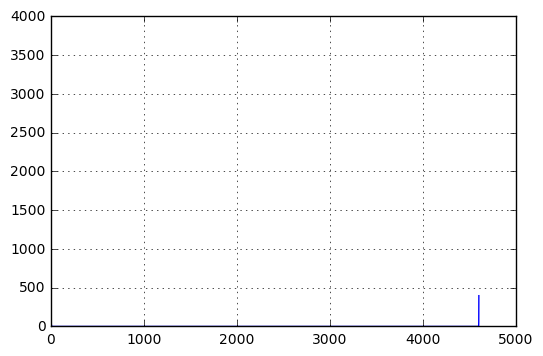

In [21]:
plot_distribution('avg_px')

Class: Wjet


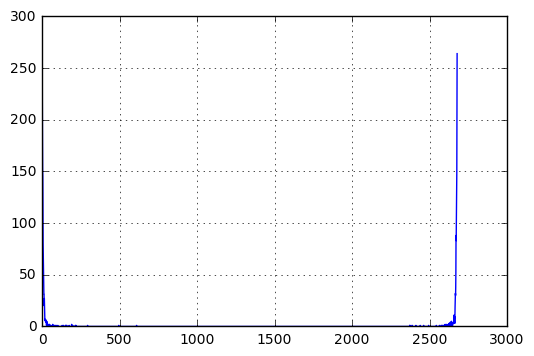

Class: SMS-T1tttt_mGl


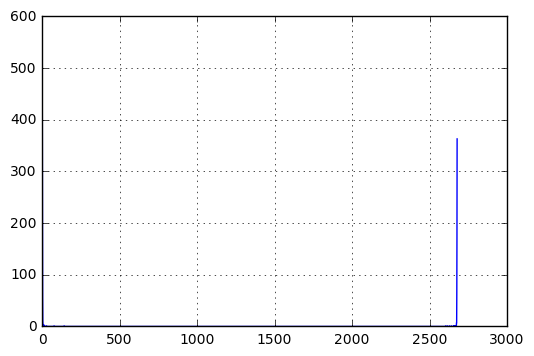

Class: DisplacedSUSY_stopToBottom


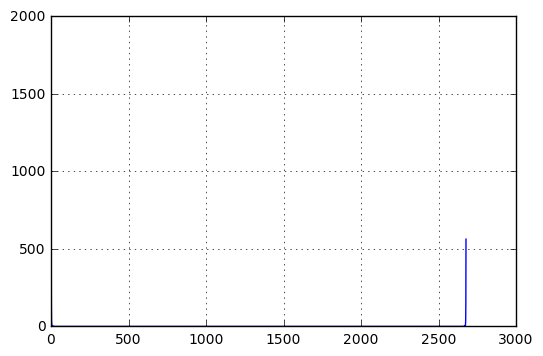

Class: RSGravitonToGaGa


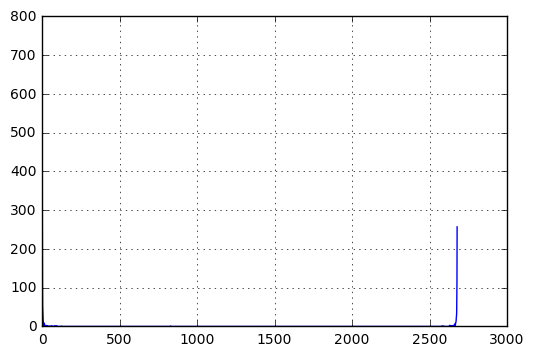

Class: PhiToMuMu


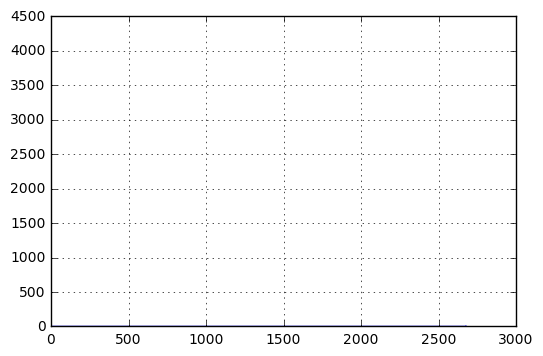

Class: H125GGgluonfusion


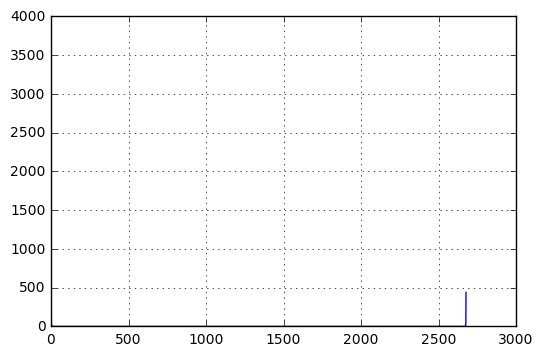

In [22]:
plot_distribution('avg_py')

Class: Wjet


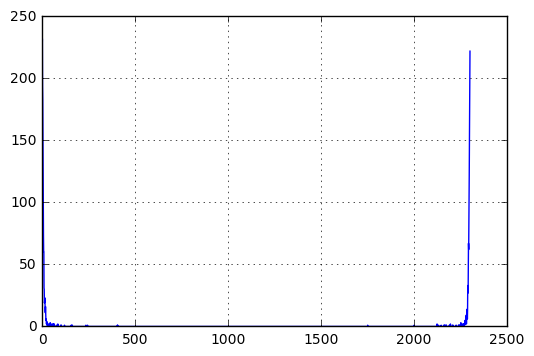

Class: SMS-T1tttt_mGl


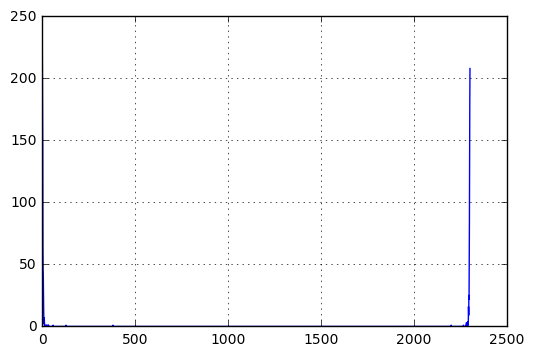

Class: DisplacedSUSY_stopToBottom


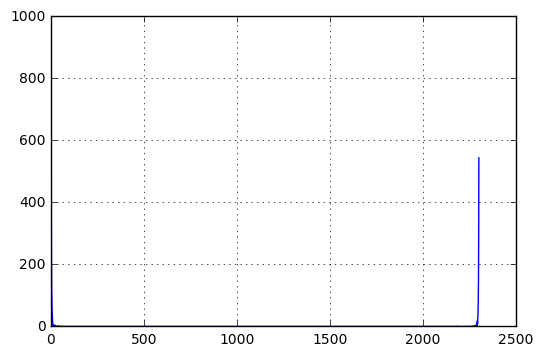

Class: RSGravitonToGaGa


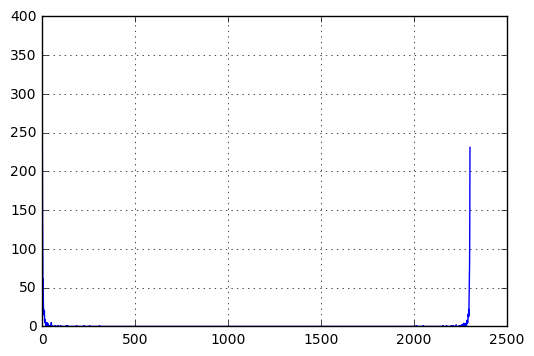

Class: PhiToMuMu


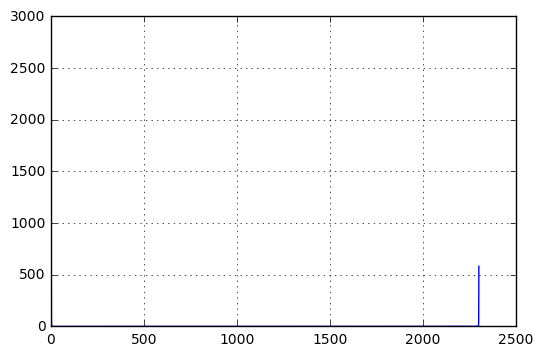

Class: H125GGgluonfusion


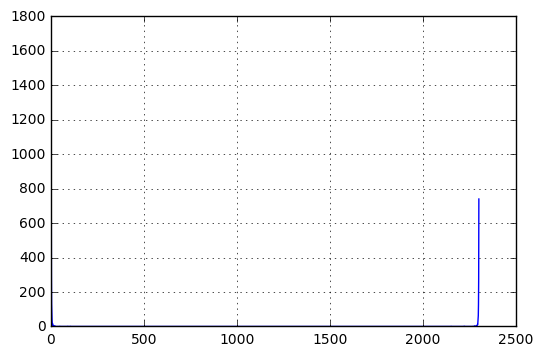

In [23]:
plot_distribution('avg_pz')

Class: Wjet


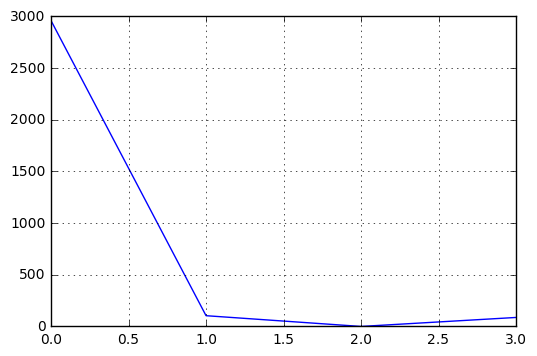

Class: SMS-T1tttt_mGl


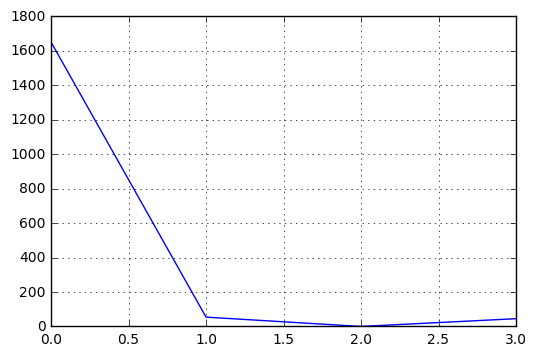

Class: DisplacedSUSY_stopToBottom


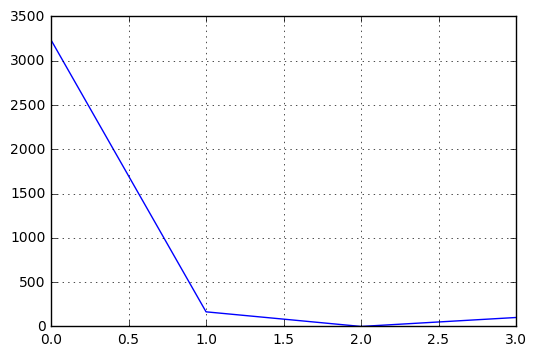

Class: RSGravitonToGaGa


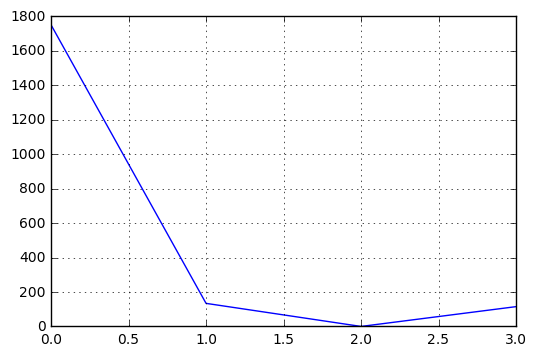

Class: PhiToMuMu


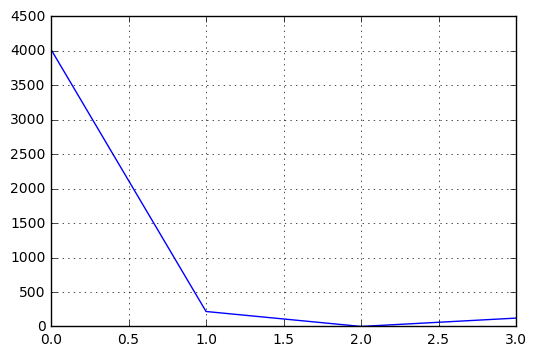

Class: H125GGgluonfusion


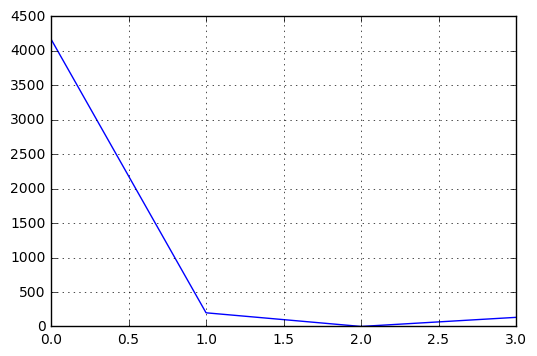

In [27]:
plot_distribution('avg_lambda')

Class: Wjet


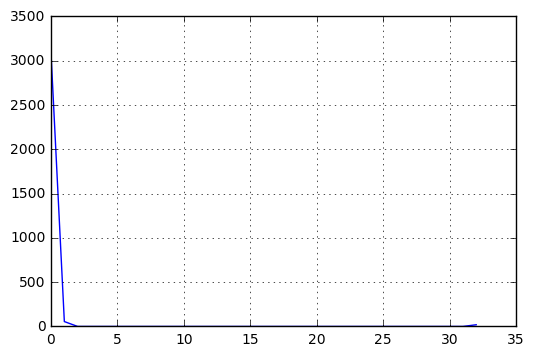

Class: SMS-T1tttt_mGl


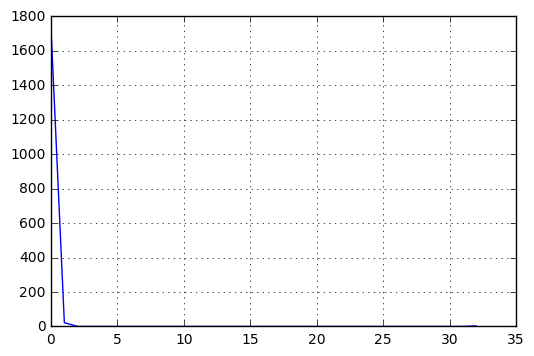

Class: DisplacedSUSY_stopToBottom


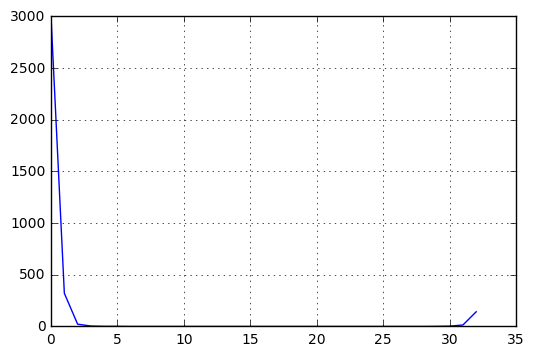

Class: RSGravitonToGaGa


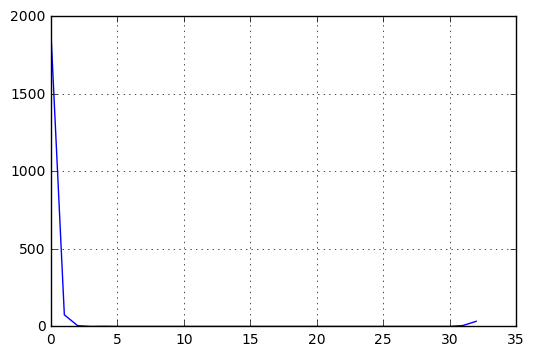

Class: PhiToMuMu


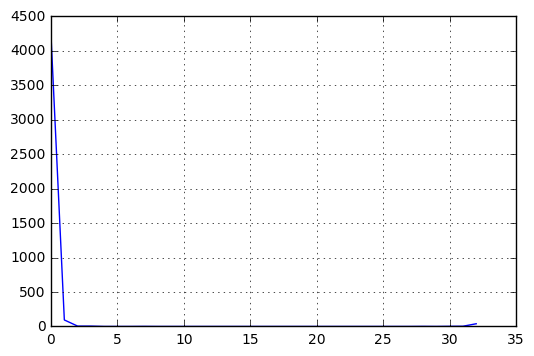

Class: H125GGgluonfusion


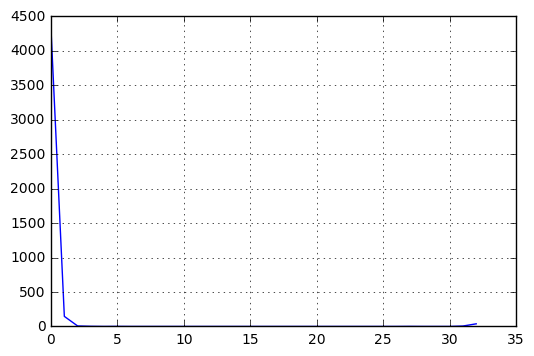

In [24]:
plot_distribution('avg_vx')

Class: Wjet


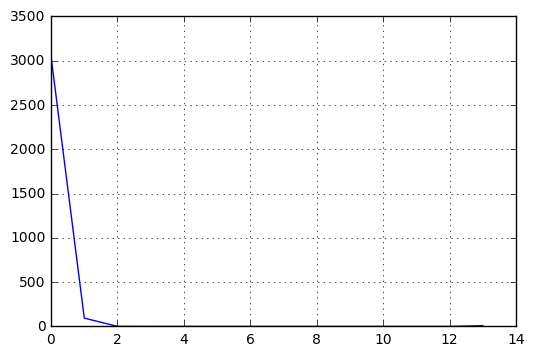

Class: SMS-T1tttt_mGl


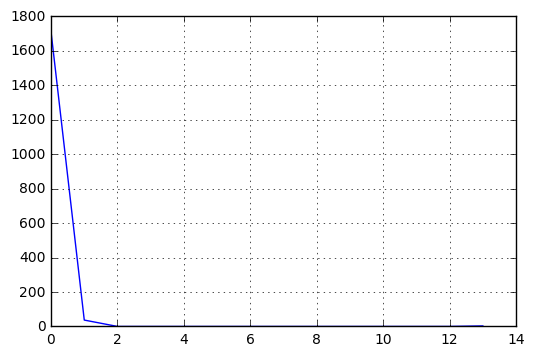

Class: DisplacedSUSY_stopToBottom


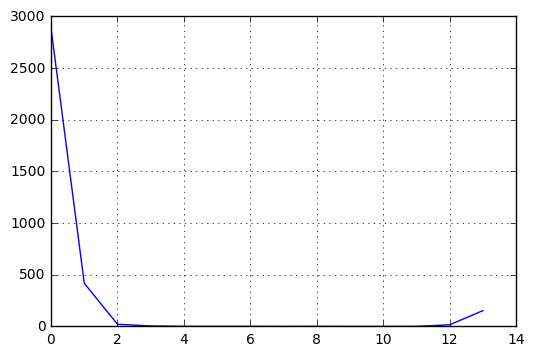

Class: RSGravitonToGaGa


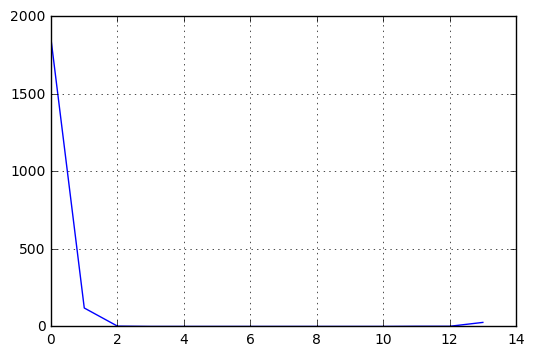

Class: PhiToMuMu


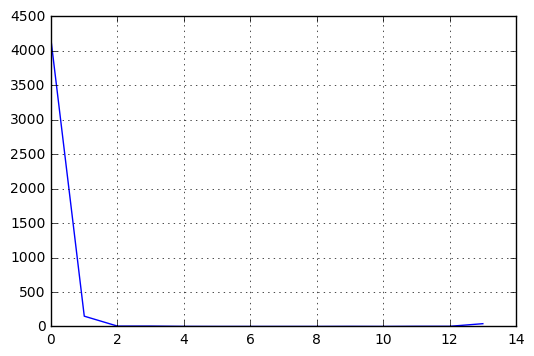

Class: H125GGgluonfusion


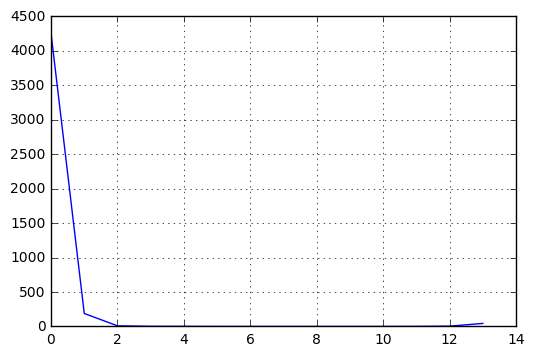

In [25]:
plot_distribution('avg_vy')

Class: Wjet


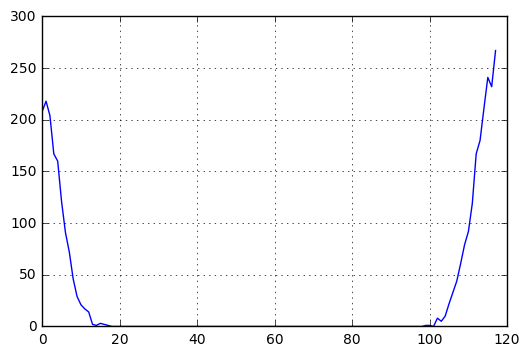

Class: SMS-T1tttt_mGl


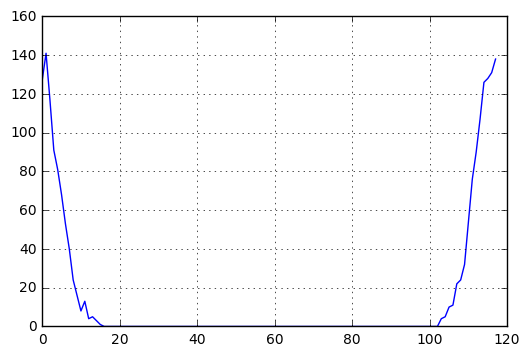

Class: DisplacedSUSY_stopToBottom


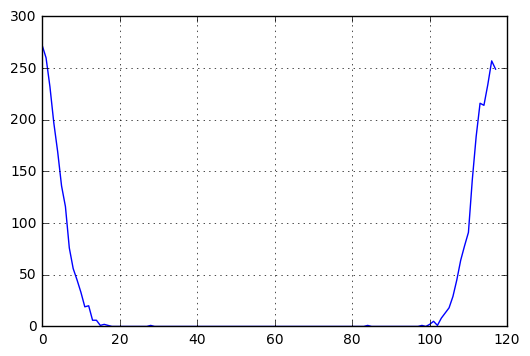

Class: RSGravitonToGaGa


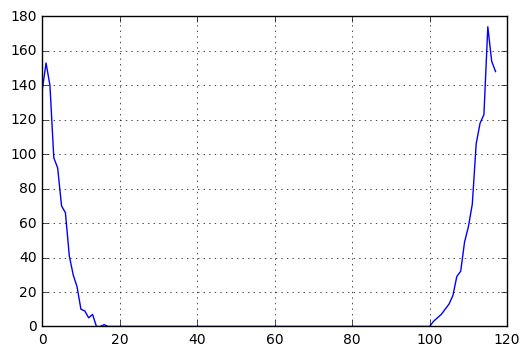

Class: PhiToMuMu


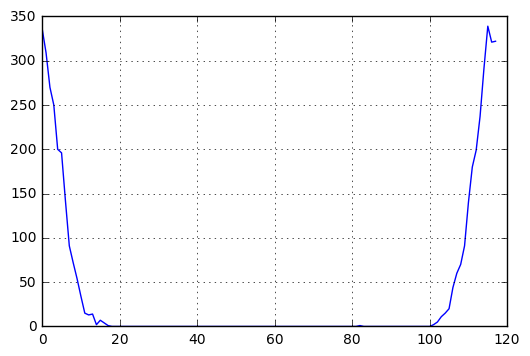

Class: H125GGgluonfusion


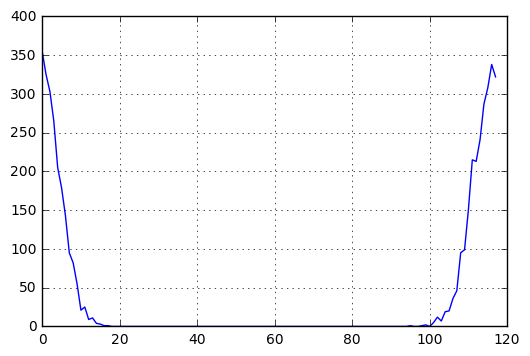

In [26]:
plot_distribution('avg_vz')

Class: Wjet


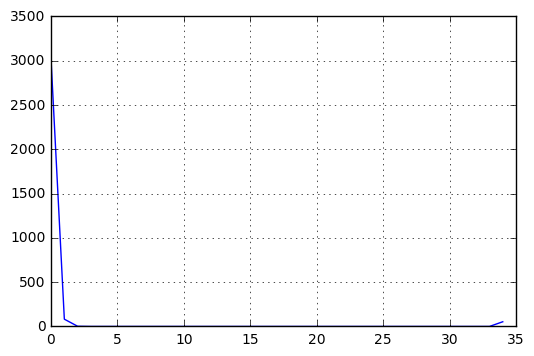

Class: SMS-T1tttt_mGl


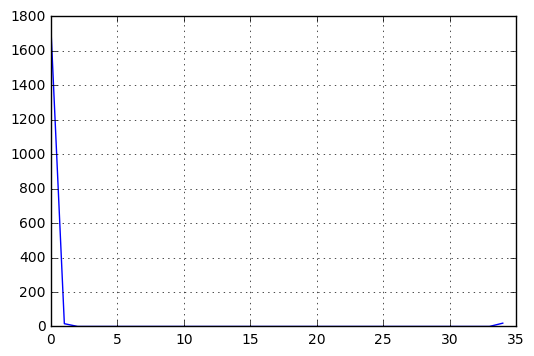

Class: DisplacedSUSY_stopToBottom


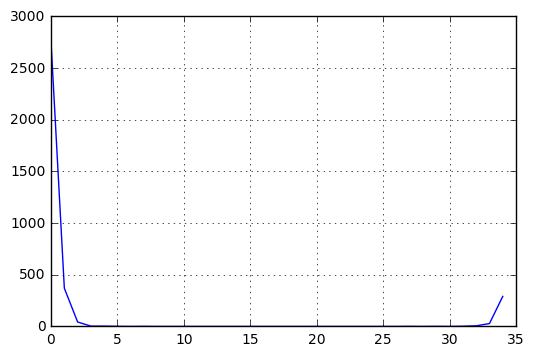

Class: RSGravitonToGaGa


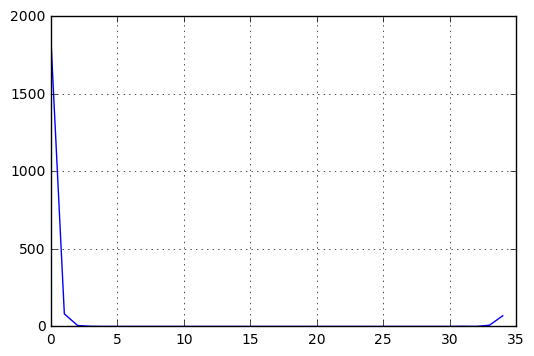

Class: PhiToMuMu


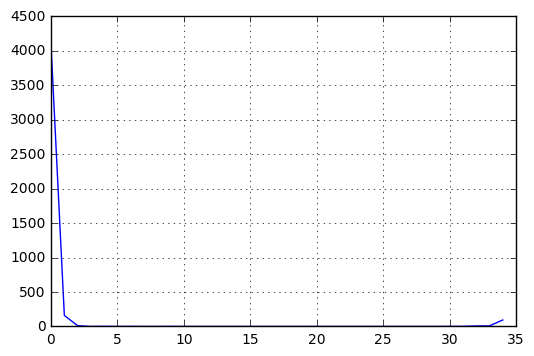

Class: H125GGgluonfusion


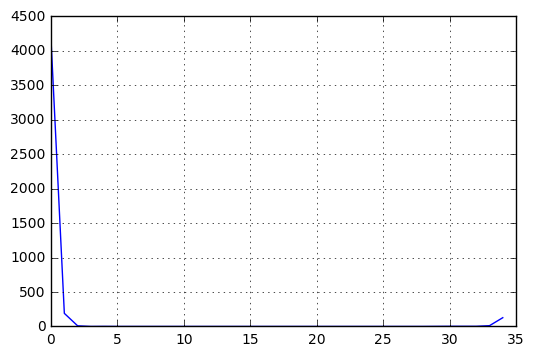

In [28]:
plot_distribution('avg_d0')